In [21]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#  biblioteca numpy que é usada para trabalhar com arrays e matrizes multidimensionais
import numpy as np 
#  biblioteca pandas que é usada para trabalhar com dados tabulares e séries temporais 
import matplotlib.pyplot as plt
#  biblioteca matplotlib que é usada para plotar gráficos 
import pandas as pd
# biblioteca pandas_datareader que é usada para importar dados do Yahoo Finance
import pandas_datareader as web
# biblioteca datetime que é usada para trabalhar com datas e horas 
import datetime as dt

# biblioteca keras que é usada para criar e treinar redes neurais
from sklearn.preprocessing import MinMaxScaler
# Sequential é uma pilha de camadas onde cada camada tem exatamente um tensor de entrada e um tensor de saída 
from tensorflow.keras.models import Sequential
# Dense é uma camada de neurônios totalmente conectados, onde cada neurônio está conectado a todos os neurônios na próxima camada
# Dropout é uma técnica de regularização que previne o overfitting 
# LSTM é uma camada de rede neural recorrente que é usada para processar sequências de dados 
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [22]:
banco = 'BBAS3.SA' # Banco do Brasil

inicio = dt.datetime(2012,1,1) # data de inicio
fim = dt.datetime(2022,11,18) # data de hoje

dados = web.DataReader(banco, 'yahoo', inicio, fim) # pega os dados do yahoo finance

In [ ]:
print(dados)

In [24]:
# Preparação dos dados
normalizando = MinMaxScaler(feature_range=(0,1)) # normalizando os dados entre 0 e 1
dados_normalizados = normalizando.fit_transform(dados['Close'].values.reshape(-1,1)) # normalizando os dados de fechamento 

previsao_dias = 3 # dias para prever

x_treinar, y_treinar = [], []

# pegando os dados de fechamento e colocando em x_treinar e y_label
for x in range(previsao_dias, len(dados_normalizados)):
    x_treinar.append(dados_normalizados[x-previsao_dias:x, 0])
    y_treinar.append(dados_normalizados[x, 0])

x_treinar, y_treinar = np.array(x_treinar), np.array(y_treinar) # transformando em array numpy 
x_treinar = np.reshape(x_treinar, (x_treinar.shape[0], x_treinar.shape[1], 1)) # redimensionando os dados

### x_treinar e y_treinar

- O x_treinar é o conjunto de dados que será utilizado para treinar o modelo, ou seja, o conjunto de dados que será utilizado para que o modelo aprenda a classificar os dados.

- E o y_treinar difere do x_treinar, pois o y_treinar é o conjunto de dados que será utilizado para treinar o modelo, ou seja, o conjunto de dados que será utilizado para que o modelo aprenda a classificar os dados.

## x_treinar.append(dados_normalizados[x-previsao_dias:x, 0])

- O x_treinar.append() é utilizado para adicionar os dados normalizados do conjunto de dados, que será utilizado para treinar o modelo, no conjunto de dados x_treinar.

## y_treinar.append(dados_normalizados[x, 0])

- O y_treinar.append() é utilizado para adicionar os dados normalizados do conjunto de dados, que será utilizado para treinar o modelo, no conjunto de dados y_treinar.

In [25]:
print(x_treinar.shape)
print(y_treinar.shape)

(2697, 3, 1)
(2697,)


In [26]:
# construindo o modelo de rede neural LSTM

modelo = Sequential()

# camada de entrada e primeira camada oculta com 25 neurônios e 3 dias de previsão 
modelo.add(LSTM(units=25, return_sequences=True, input_shape=(x_treinar.shape[1], 1))) 
# camada de dropout para evitar overfitting 
modelo.add(Dropout(0.2)) # camada de dropout para evitar overfitting 
# 50 neurônios, return_sequences=True para retornar a sequência, 
# input_shape=(x_treinar.shape[1], 1) para pegar a quantidade de dias e 
# 1 para pegar o valor de fechamento
modelo.add(LSTM(units=25, return_sequences=True)) 
# camada de dropout para evitar overfitting 
modelo.add(Dropout(0.2)) 
# 50 neurônios, return_sequences=True para retornar a sequência
modelo.add(LSTM(units=25))
# camada de dropout para evitar overfitting
modelo.add(Dropout(0.2))
# camada de saída com 1 neurônio
modelo.add(Dense(units=1)) 

# Anotações do código

## Sequential

- É uma pilha de camadas onde cada camada tem exatamente um tensor de entrada e um tensor de saída. (Ex: camada de entrada, camada oculta, camada de saída), tensor é um array multidimensional.

## overfitting

- overfitting: quando o modelo se ajusta muito bem aos dados de treino, mas não generaliza bem para dados de teste (ou seja, não consegue prever bem os dados de teste) 

In [27]:
# compilando o modelo com o otimizador adam que é um otimizador estocástico de gradiente descendente
modelo.compile(optimizer='adam', loss='mean_squared_error')

modelo.fit(x_treinar, y_treinar, epochs=25, batch_size=32)

Epoch 1/25
85/85 [==============================] - 6s 4ms/step - loss: 0.0603
Epoch 2/25
85/85 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 3/25
85/85 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 4/25
85/85 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 5/25
85/85 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 6/25
85/85 [==============================] - 0s 4ms/step - loss: 0.0039
Epoch 7/25
85/85 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 8/25
85/85 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 9/25
85/85 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 10/25
85/85 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 11/25
85/85 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 12/25
85/85 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 13/25
85/85 [==============================

### Otimizador Adam

- Otimizador Adam: é um otimizador que usa o gradiente estocástico para atualizar os pesos da rede neural, ele é baseado no algoritmo de Adam, que é um algoritmo de otimização estocástica baseado em estimativas adaptativas de momentos.

### Modelo-fit

- Modelo-fit: é o processo de treinamento do modelo, onde o modelo é ajustado aos dados de treino.

In [28]:
print(modelo.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 3, 25)             2700      
                                                                 
 dropout_3 (Dropout)         (None, 3, 25)             0         
                                                                 
 lstm_4 (LSTM)               (None, 3, 25)             5100      
                                                                 
 dropout_4 (Dropout)         (None, 3, 25)             0         
                                                                 
 lstm_5 (LSTM)               (None, 25)                5100      
                                                                 
 dropout_5 (Dropout)         (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [29]:
# Testando o modelo com os dados de teste do futuro

# preparndo alguns dados para testar o modelo
teste_inicial = dt.datetime(2021,1,1) # data de inicio
teste_final = dt.datetime.now() # data de hoje

dados_teste = web.DataReader(banco, 'yahoo', teste_inicial, teste_final) # pega os dados do yahoo finance
precos_reais = dados_teste['Close'].values # pega os valores de fechamento

total_dados = pd.concat((dados['Close'], dados_teste['Close']), axis=0) # concatena os dados de treino e teste

modelo_entradas = total_dados[len(total_dados) - len(dados_teste) - previsao_dias:].values # pega os dados de entrada
modelo_entradas = modelo_entradas.reshape(-1,1) # redimensiona os dados
modelo_entradas = normalizando.transform(modelo_entradas) # normaliza os dados


## total_dados = pd.concat((dados['Close'], dados_teste['Close']), axis=0)

- O total_dados = pd.concat() é utilizado para concatenar os dados de treino e os dados de teste, ou seja, o total_dados é o conjunto de dados que será utilizado para treinar o modelo e para testar o modelo. o axis=0 é utilizado para concatenar os dados de forma vertical.

## modelo_entrada

- O modelo_entrada é o conjunto de dados que será utilizado para testar o modelo, ou seja, o conjunto de dados que será utilizado para que o modelo classifique os dados.

In [ ]:
print(modelo_entradas)

In [31]:
# fazendo as previsões

x_teste = []

for x in range(previsao_dias, len(modelo_entradas)):
    x_teste.append(modelo_entradas[x-previsao_dias:x, 0])

x_teste = np.array(x_teste) # transformando em array numpy
x_teste = np.reshape(x_teste, (x_teste.shape[0], x_teste.shape[1], 1)) # redimensionando os dados

previsao_precos = modelo.predict(x_teste) # fazendo as previsões
previsao_precos = normalizando.inverse_transform(previsao_precos) # desnormalizando os dados 

15/15 [==============================] - 1s 1ms/step


### x_teste = np.reshape(x_teste, (x_teste.shape[0], x_teste.shape[1], 1))

- O x_teste = np.reshape() é utilizado para redimensionar o conjunto de dados que será utilizado para testar o modelo, ou seja, o conjunto de dados que será utilizado para que o modelo classifique os dados.

### previsao_precos = modelo.predict(x_teste)

- O previsao_precos = modelo.predict() é utilizado para prever os preços dos dados que serão utilizados para testar o modelo, ou seja, o conjunto de dados que será utilizado para que o modelo classifique os dados.

In [42]:
print(x_teste.shape)

(472, 3, 1)


In [33]:
print(x_teste.shape)

(472, 3, 1)


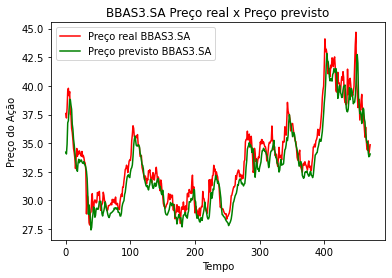

In [34]:
# representação gráfica dos dados

plt.plot(precos_reais, color='red', label=f'Preço real {banco}')
plt.plot(previsao_precos, color='green', label=f'Preço previsto {banco}')
plt.title(f'{banco} Preço real x Preço previsto')
plt.xlabel('Tempo')
plt.ylabel('Preço do Ação')
plt.legend()
plt.show()

In [35]:
# pegando os dados de fechamento e colocando em x_treinar e y_treinar para prever os próximos dias
dados_reais = [modelo_entradas[len(modelo_entradas) + 1 - previsao_dias:len(modelo_entradas+1), 0]] 
dados_reais = np.array(dados_reais) # transformando em array numpy
dados_reais = np.reshape(dados_reais, (dados_reais.shape[0], dados_reais.shape[1], 1)) # redimensionando os dados

### dados_reais

- A variável dados_reais é o conjunto de dados que foi utilizado para testar o modelo, ou seja, o conjunto de dados que foi utilizado para que o modelo classificasse os dados.

In [36]:
print(dados_reais.shape)

(1, 2, 1)


In [44]:
previsao = modelo.predict(dados_reais) # fazendo as previsões
print(previsao)
previsao = normalizando.inverse_transform(previsao) # desnormalizando os dados
print(previsao)

1/1 [==============================] - 0s 20ms/step
[[0.36342248]]
[[28.138187]]


### previsao = normalizando.inverse_transform(previsao)

- O previsao = normalizando.inverse_transform() é utilizado para desnormalizar os dados que foram normalizados pois o modelo somente aceita dados normalizados.

In [38]:
print(f'Preço previsto para amanhã: {previsao}')

Preço previsto para amanhã: [[28.138187]]
